In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from glob import glob
from sklearn.utils import shuffle

from config import efficientNet_config
from models import efficientNetV2B0_model, efficientNetV2B3_model
from utils import plt_heatmap, plt_roccurve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import os
# 使用第二張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
height  = efficientNet_config['height_B0']
width   = efficientNet_config['width_B0']

# 載入測試資料

In [3]:
test_dir      = '../dataset_smooth_186video_20230323/test'    # !!!!!!!!!!!!!!!
# test_dir      = '../dataset_186video_20230323/test'           # !!!!!!!!!!!!!!!

# test_dir      = '../dataset_smooth_22video_20221031/test/'  ##　這邊改資料集
# test_dir      = '../dataset_smooth_22video_20221031/train/'
# test_dir      = '../dataset_smooth_22video_20221031/validation/'
test_img_arrays = []
test_img_labels = []
test_img_names  = []

## test
img_paths = glob(test_dir + "/0/*.png")
for img_path in img_paths:
    # image
    img_array = cv.imread(img_path)
    img_array = cv.resize(img_array,(height,width))     # resize to (224,224)
    test_img_arrays.append(img_array)
    # label
    test_img_labels.append([0])
    # name
    test_img_names.append(img_path.split("/")[-1])

img_paths = glob(test_dir + "/1/*.png")
for img_path in img_paths:
    # image
    img_array = cv.imread(img_path)
    img_array = cv.resize(img_array,(height,width))      # resize to (224,224)
    test_img_arrays.append(img_array)
    # label
    test_img_labels.append([1])
    # name
    test_img_names.append(img_path.split("/")[-1])

In [4]:
test_img_arrays = np.array(test_img_arrays)
test_img_labels = np.array(test_img_labels)

In [5]:
print("測試集維度= ", test_img_arrays.shape)

測試集維度=  (3007, 224, 224, 3)


# 載入模型

In [6]:
model = efficientNetV2B0_model()
model.load_weights('../model/202303/20230329.weights')

# 最後一個epoch的模型
# from tensorflow import keras
# model = keras.models.load_model('../model/202303/20230401_lastepoch.h5')

2023-04-08 21:30:24.896638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-08 21:30:24.901180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-08 21:30:24.901867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-08 21:30:24.902633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


# 打亂

In [7]:
# test_img_arrays, test_img_labels = shuffle(test_img_arrays,test_img_labels)

In [8]:
# test_img_arrays.shape

# 預測

In [9]:
pred_result = model.predict(test_img_arrays)

2023-04-08 21:30:29.491518: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


94/94 [==============================] - 4s 27ms/step


# 結果

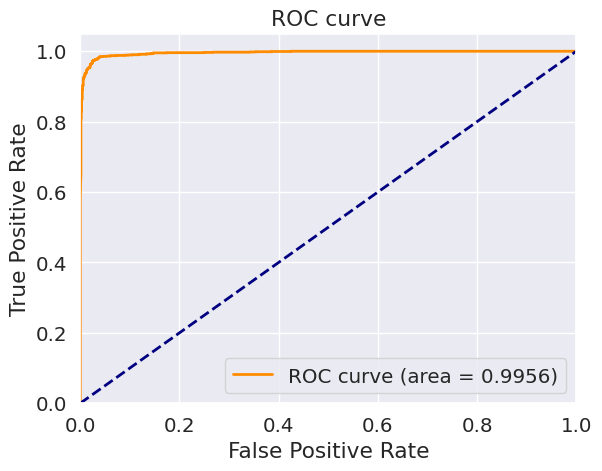

In [10]:
fpr, tpr, thresholds = roc_curve(test_img_labels, pred_result, pos_label=1) 
roc_auc = auc(fpr, tpr)
plt_roccurve(fpr,tpr,roc_auc)

In [11]:
pred_result = np.where(pred_result > 0.5, 1,0)
tn, fp, fn, tp = confusion_matrix(test_img_labels, pred_result).ravel()
sensitivity = round(tp / (tp+fn), 4)
specificity = round(tn / (tn+fp), 4)
balanced_acc= round((sensitivity+specificity)/2, 4)
precision   = round(tp / (tp+fp), 4)
f1score     = round(2/((1/precision)+(1/sensitivity)), 4)
accuracy    = round((tp+tn)/(tn+fp+fn+tp), 4)

print('Sensitivity= ',sensitivity)
print('Specificity= ',specificity)
print('Balanced_acc= ',balanced_acc)
print('Precision= ', precision)
print('f1score= ', f1score)
print('Accuracy= ',accuracy)

Sensitivity=  0.9636
Specificity=  0.9779
Balanced_acc=  0.9708
Precision=  0.9779
f1score=  0.9707
Accuracy=  0.9707


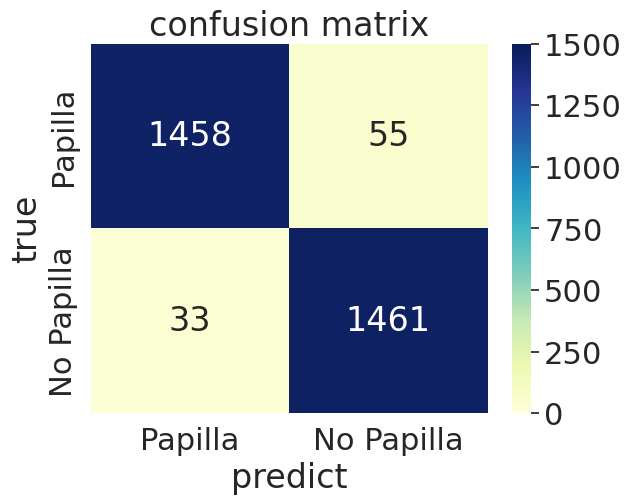

In [12]:
plt_heatmap([[tp,fn],[fp,tn]])

# 把stage1結果存起來，給stage2用

In [17]:
test_dict = {
 "test_name" : test_img_names,
 "test_true" : test_img_labels.reshape(-1),
 "stage1_test_pred" : pred_result.reshape(-1)
}


In [18]:
pd.DataFrame(test_dict).to_pickle("../result/stage1_pred_result_test_20230323.pickle")
# pd.DataFrame(test_dict).to_pickle("../result/stage1_pred_result_test.pickle")
# pd.DataFrame(test_dict).to_pickle("../result/stage1_pred_result_test_nosmooth.pickle")

# pd.DataFrame(test_dict).to_pickle("../result/stage1_pred_result_train.pickle")
# pd.DataFrame(test_dict).to_pickle("../result/stage1_pred_result_validation.pickle")

: 

In [15]:
pd.DataFrame(test_dict)

,test_name,test_true,stage1_test_pred
0,20210305_00001.png,0,0
1,20210305_00002.png,0,0
2,20210305_00003.png,0,0
3,20210305_00004.png,0,0
4,20210305_00005.png,0,0
...,...,...,...
3002,20221206_00041.png,1,1
3003,20221206_00042.png,1,1
3004,20221206_00043.png,1,1
3005,20221206_00044.png,1,1
